# Vodafone Ziggo: cluster analysis using the Skynet case


## Import data

   Import data from a local csv file

In [1]:
# load libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# make sure all graphical output from mathplotlib is shown
%matplotlib inline

In [2]:
# Are we in the right place?
os.getcwd()

'C:\\Users\\daffourtit\\OneDrive - VodafoneZiggo\\Opdracht Python Clustering'

In [3]:
df = pd.read_csv('Skynet_input_clustering_full.csv' ,sep = ';', decimal = '.')

In [4]:
# Data is a different directory: specify where (alleen als je data ergens anders staat)
#in_path = os.path.join('C:\\temp\\talent program', 'Skynet_input_clustering_sample.csv')

#df_2 = pd.read_csv(in_path ,sep = ';', decimal = '.')

In [5]:
# check, do we have data ;)
df.head()

,customers_id,urbanisation,age,gender,NPS,subscription,subscription_add_on,customer_lifetime,GB_usage_month,service_calls_year,perc_payment_on_time,marketing_optin,account_login_3_months,mechanic_year,survey_changes,survey_news,survey_usage,survey_support,survey_payment
0,146113,1,16.0,M,8,Complete,no add-ons,less then 12 months,53,0,1.0,Y,N,0,2.315,3.677,2.540,4.485,3.910
1,414632,1,36.0,F,10,Internet only Compact,no add-ons,> 5 years,92,0,1.0,N,Y,0,4.843,2.583,4.783,1.800,2.835
2,377220,2,17.0,M,8,Complete,no add-ons,less then 12 months,40,0,1.0,N,N,0,1.775,4.859,1.991,4.599,3.946
3,244103,1,39.0,M,10,Internet only Compact,no add-ons,> 5 years,93,0,1.0,N,Y,1,2.676,3.355,4.299,3.473,3.072
4,450183,2,20.0,M,9,Internet & Television Plus,no add-ons,less then 12 months,43,0,1.0,Y,Y,0,3.363,4.200,4.104,4.523,3.280


In [6]:
# do we have all data?
df.shape

(27637, 19)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27637 entries, 0 to 27636
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customers_id            27637 non-null  int64  
 1   urbanisation            27637 non-null  int64  
 2   age                     26787 non-null  float64
 3   gender                  27637 non-null  object 
 4   NPS                     27637 non-null  int64  
 5   subscription            27637 non-null  object 
 6   subscription_add_on     27637 non-null  object 
 7   customer_lifetime       27637 non-null  object 
 8   GB_usage_month          27637 non-null  int64  
 9   service_calls_year      27637 non-null  int64  
 10  perc_payment_on_time    27637 non-null  float64
 11  marketing_optin         27637 non-null  object 
 12  account_login_3_months  27637 non-null  object 
 13  mechanic_year           27637 non-null  int64  
 14  survey_changes          26809 non-null

## Data preparation

- missing values
- outliers
- compute dummies for categories (can also be done in source)
- selection (correlation plot: do not select variables that correlate too high)
- normalization

### Missing values
K-means cannot handle missing values, so find out if your dataset has missing values and solve any NAs

In [8]:
# Do we have missing values?
df.isna().sum().sort_values()

customers_id                0
mechanic_year               0
account_login_3_months      0
marketing_optin             0
perc_payment_on_time        0
GB_usage_month              0
customer_lifetime           0
service_calls_year          0
subscription                0
NPS                         0
gender                      0
urbanisation                0
subscription_add_on         0
survey_news               552
survey_payment            552
survey_usage              827
survey_support            828
survey_changes            828
age                       850
dtype: int64

In [9]:
# If you do encounter missing values you can either remove the record or substitute it 
# with another value, like the mean or median. inplace=True > replace original, else a copy will be made.

# niet voor de surveys, die gebruik ik niet in de clustering

df['survey_news'].fillna((df['survey_news'].mean()), inplace=True)
df['survey_payment'].fillna((df['survey_payment'].mean()), inplace=True)
df['survey_usage'].fillna((df['survey_usage'].mean()), inplace=True)
df['survey_support'].fillna((df['survey_support'].mean()), inplace=True)
df['survey_changes'].fillna((df['survey_changes'].mean()), inplace=True)

# Replace missing values on age with the mean
df['age'].fillna((df['age'].mean()), inplace=True)

# Make sure age is an integer and not a float
df['age'] = df['age'].astype('int64')


In [10]:

df.isna().sum().sort_values()

customers_id              0
survey_usage              0
survey_news               0
survey_changes            0
mechanic_year             0
account_login_3_months    0
marketing_optin           0
perc_payment_on_time      0
survey_support            0
service_calls_year        0
customer_lifetime         0
subscription_add_on       0
subscription              0
NPS                       0
gender                    0
age                       0
urbanisation              0
GB_usage_month            0
survey_payment            0
dtype: int64

### Inspect your data and deal with outliers

<AxesSubplot:xlabel='survey_payment'>

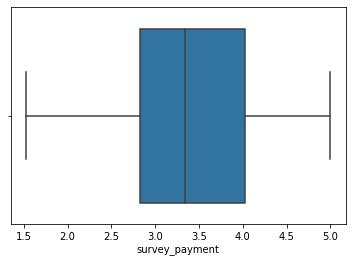

In [11]:
# Use a boxplot to inspect your data
sns.boxplot(x=df['survey_payment'])

<AxesSubplot:>

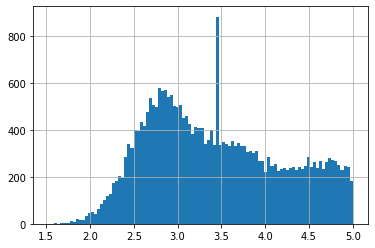

In [12]:
# Or use the histogram function in pandas
df['survey_payment'].hist(bins=100)

<AxesSubplot:xlabel='urbanisation', ylabel='survey_support'>

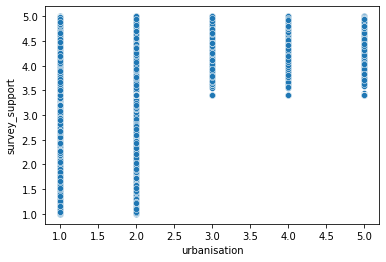

In [13]:
# Alternative: use a scatterplot against another variable
sns.scatterplot(x=df['urbanisation'], y=df['survey_support'])

<AxesSubplot:xlabel='age'>

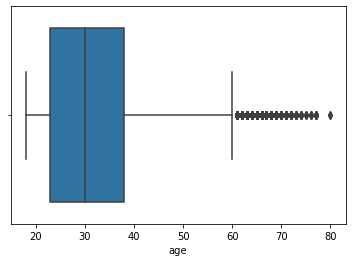

In [14]:
# You can use a function to remove all values above or below 1.5 times the IQR, or replace values you see fit
# Here we substitute people with age 0 with the mean
df['age'] = np.where(df['age'] == 0 , df['age'].mean(), df['age']).astype('int64')
df['age'] = np.where(df['age'] <= 17 , 18, df['age']).astype('int64')

# And what about people older than 80 years?
df['age'] = np.where(df['age'] >=80 , 80, df['age']).astype('int64')

# Check results
sns.boxplot(x=df['age'])

### Create numeric variables as input
K-mean can handle only numeric input, so we need to dummify categories (if you have them in your data).

In [15]:
# Which variabels are not numeric?
df.describe(exclude=[np.number])

,gender,subscription,subscription_add_on,customer_lifetime,marketing_optin,account_login_3_months
count,27637,27637,27637,27637,27637,27637
unique,3,6,4,4,2,2
top,F,Complete,no add-ons,> 5 years,N,Y
freq,15187,11757,21840,17513,15183,17366


In [16]:
df['subscription'].value_counts()

Complete                          11757
Internet & Television Plus         6572
Internet only Compact              5638
Internet & Television\tCompact     2197
Internet & Telephone Plus          1463
Internet & Telephone\tCompact        10
Name: subscription, dtype: int64

In [17]:
# kleine categorie uit lifetime samenvoegen
df['CL'] = np.where(df['customer_lifetime'] == 'between 12 and 24 months','less then 24 months',df['customer_lifetime'])
df['CL'] = np.where(df['CL'] == 'less then 12 months','less then 24 months',df['CL'])

In [18]:
# account login numeriek maken met 1 en 0
df['Acc_Login'] = np.where(df['account_login_3_months'] == 'Y',1,0)
df.head()

,customers_id,urbanisation,age,gender,NPS,subscription,subscription_add_on,customer_lifetime,GB_usage_month,service_calls_year,...,marketing_optin,account_login_3_months,mechanic_year,survey_changes,survey_news,survey_usage,survey_support,survey_payment,CL,Acc_Login
0,146113,1,18,M,8,Complete,no add-ons,less then 12 months,53,0,...,Y,N,0,2.315,3.677,2.540,4.485,3.910,less then 24 months,0
1,414632,1,36,F,10,Internet only Compact,no add-ons,> 5 years,92,0,...,N,Y,0,4.843,2.583,4.783,1.800,2.835,> 5 years,1
2,377220,2,18,M,8,Complete,no add-ons,less then 12 months,40,0,...,N,N,0,1.775,4.859,1.991,4.599,3.946,less then 24 months,0
3,244103,1,39,M,10,Internet only Compact,no add-ons,> 5 years,93,0,...,N,Y,1,2.676,3.355,4.299,3.473,3.072,> 5 years,1
4,450183,2,20,M,9,Internet & Television Plus,no add-ons,less then 12 months,43,0,...,Y,Y,0,3.363,4.200,4.104,4.523,3.280,less then 24 months,1


In [19]:
# Create a new dataframe with all the input for the cluster analysis, starting with all numeric columns
df_input = df.select_dtypes(include = 'number')

# Show
df_input.head()

,customers_id,urbanisation,age,NPS,GB_usage_month,service_calls_year,perc_payment_on_time,mechanic_year,survey_changes,survey_news,survey_usage,survey_support,survey_payment,Acc_Login
0,146113,1,18,8,53,0,1.0,0,2.315,3.677,2.540,4.485,3.910,0
1,414632,1,36,10,92,0,1.0,0,4.843,2.583,4.783,1.800,2.835,1
2,377220,2,18,8,40,0,1.0,0,1.775,4.859,1.991,4.599,3.946,0
3,244103,1,39,10,93,0,1.0,1,2.676,3.355,4.299,3.473,3.072,1
4,450183,2,20,9,43,0,1.0,0,3.363,4.200,4.104,4.523,3.280,1


In [20]:
# Specify which variables you want to dummify, example
pd.get_dummies(df['CL'], prefix='CL', drop_first=False, dummy_na= False)

,CL_2 - 5 years,CL_> 5 years,CL_less then 24 months
0,0,0,1
1,0,1,0
2,0,0,1
3,0,1,0
4,0,0,1
...,...,...,...
27632,0,1,0
27633,0,1,0
27634,0,1,0
27635,0,1,0


In [21]:
# Add dummified data for gender to your dataframe
df_input = pd.concat([df_input, pd.get_dummies(df['gender'], prefix='gender', drop_first=False, dummy_na= False)],axis=1)

# Add dummified data for gender to your dataframe
df_input = pd.concat([df_input, pd.get_dummies(df['CL'], prefix='CL', drop_first=False, dummy_na= False)],axis=1)

# Add dummified data for online login to your dataframe
df_input = pd.concat([df_input, pd.get_dummies(df['marketing_optin'], prefix='optin', drop_first=False, dummy_na= False)],axis=1)

# Add dummified data for online login to your dataframe
#df_input = pd.concat([df_input, pd.get_dummies(df['account_login_3_months'], prefix='login', drop_first=False, dummy_na= False)],axis=1)

df_input.head()

,customers_id,urbanisation,age,NPS,GB_usage_month,service_calls_year,perc_payment_on_time,mechanic_year,survey_changes,survey_news,...,survey_payment,Acc_Login,gender_F,gender_M,gender_U,CL_2 - 5 years,CL_> 5 years,CL_less then 24 months,optin_N,optin_Y
0,146113,1,18,8,53,0,1.0,0,2.315,3.677,...,3.910,0,0,1,0,0,0,1,0,1
1,414632,1,36,10,92,0,1.0,0,4.843,2.583,...,2.835,1,1,0,0,0,1,0,1,0
2,377220,2,18,8,40,0,1.0,0,1.775,4.859,...,3.946,0,0,1,0,0,0,1,1,0
3,244103,1,39,10,93,0,1.0,1,2.676,3.355,...,3.072,1,0,1,0,0,1,0,1,0
4,450183,2,20,9,43,0,1.0,0,3.363,4.200,...,3.280,1,0,1,0,0,0,1,0,1


In [ ]:
#df_input.drop(columns = ['gender_F', 'gender_U', 'optin_N'], inplace = True)

In [ ]:
df_input.head()

## K-means clustering

- choose variables that are input for clustering > not to high corrrelations
- determine # clusters using elbow measure or silhouette score
- difference between normalized data and raw data

(22.0, 0.0)

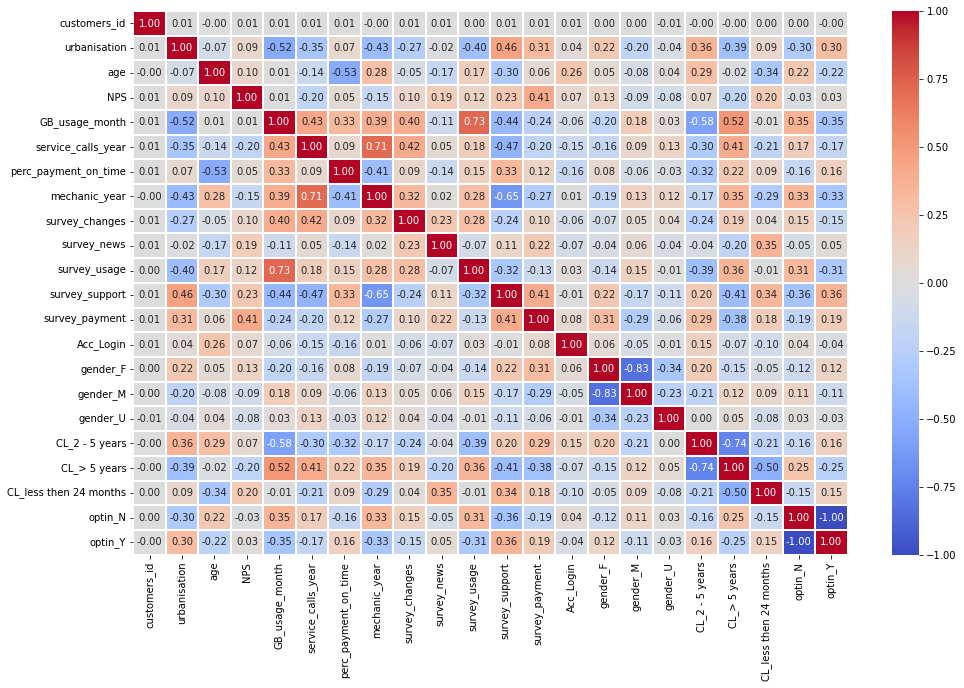

In [22]:
# Can we add all data, first check for high correlations
corrMatrix = df_input.select_dtypes(include = 'number').corr()

# Clearly number 
plt.figure(figsize=(16,10))
corrMatrixDisplay = sns.heatmap(corrMatrix, annot=True, linewidths=2, cmap='coolwarm', fmt='.2f')
corrMatrixDisplay.set_ylim(sorted(corrMatrixDisplay.get_xlim(), reverse=True)) # fit top & bottom limits for mathplotlib

In [23]:
# nieuwe var maken op basis van service_calls en mechanic
# eerst service_calls_year naar max 9
df_input['SC_Year'] = np.where(df['service_calls_year'] > 9 ,9,df['service_calls_year'])
#np.unique(df_input['SC_Year'], return_counts=True)
# dan 10 * mechanic + sc_year als nieuwe metric
df_input['service_year'] = (df_input['mechanic_year']*10) + df_input['SC_Year']
np.unique(df_input['service_year'], return_counts=True)

(array([ 0,  1, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 36, 37, 38, 39], dtype=int64),
 array([14861,   409,  3741,   616,   914,   960,  1009,   825,   540,
          204,   772,    60,     4,    13,    40,   170,   398,   638,
          684,   584,    66,    19,     1,     4,     6,    99],
       dtype=int64))

In [24]:
# Drop the variables we do not use because of to high correlation
# dropping all survey variables to see what happens
#df_input.drop(columns = ['survey_usage', 'survey_support', 'survey_changes','survey_payment','survey_news'], inplace = True)
# dropping service_calls_year, SC_Year en mechanic_year
#df_input.drop(columns = ['service_calls_year', 'SC_Year', 'mechanic_year'], inplace = True)

(24.0, 0.0)

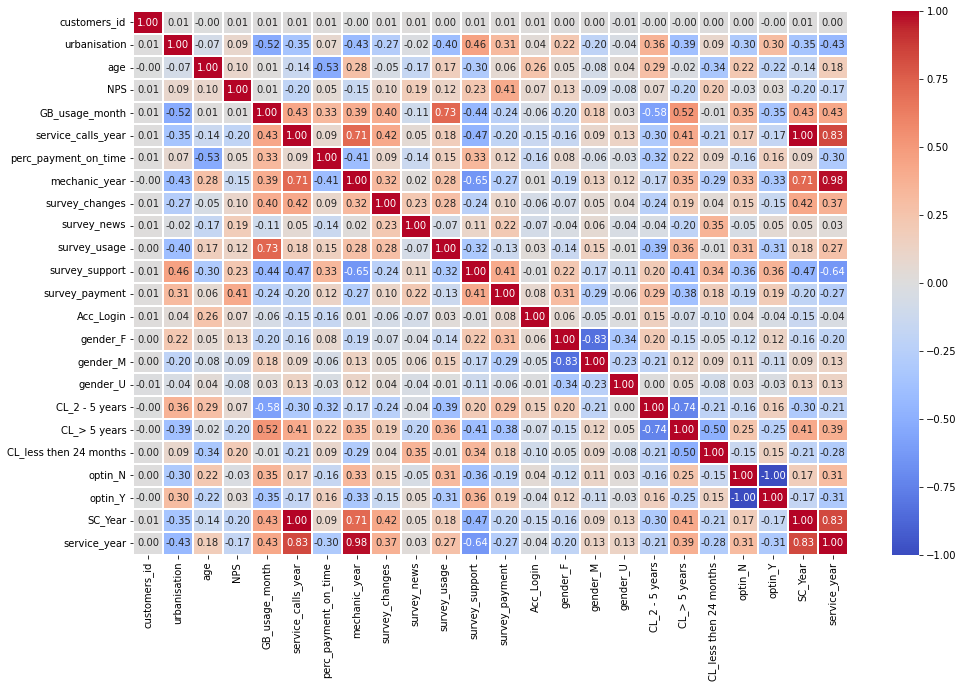

In [25]:
# Can we add all data, first check for high correlations
corrMatrix = df_input.select_dtypes(include = 'number').corr()

# Clearly number 
plt.figure(figsize=(16,10))
corrMatrixDisplay = sns.heatmap(corrMatrix, annot=True, linewidths=2, cmap='coolwarm', fmt='.2f')
corrMatrixDisplay.set_ylim(sorted(corrMatrixDisplay.get_xlim(), reverse=True)) # fit top & bottom limits for mathplotlib

In [26]:
# Standardize the input, clusters will tend to be separated along variables with greater variance

# define standard scaler
scaler = StandardScaler()

# save the ID field, we don't want to scale it
ID = df_input['customers_id']

# fit scaler on all remaining fields
scaler.fit(df_input.drop('customers_id', axis = 1))

# Calculate scaled values and store them in a separate object
scaled_values = scaler.transform(df_input.drop('customers_id', axis = 1))

# Create a dataframe, add column names and put ID field back
df_scaled = pd.DataFrame(scaled_values, index = df_input.index, columns = df_input.drop('customers_id', axis = 1).columns)
df_scaled['customers_id'] = ID
df_scaled.head()

,urbanisation,age,NPS,GB_usage_month,service_calls_year,perc_payment_on_time,mechanic_year,survey_changes,survey_news,survey_usage,...,gender_M,gender_U,CL_2 - 5 years,CL_> 5 years,CL_less then 24 months,optin_N,optin_Y,SC_Year,service_year,customers_id
0,-0.639235,-1.259329,0.669085,0.299845,-0.542914,0.352183,-0.802123,-0.897155,0.103369,-0.397180,...,1.326900,-0.311116,-0.563742,-1.315238,2.643838,-1.104141,1.104141,-0.546954,-0.780541,146113
1,-0.639235,0.391605,1.418351,1.490992,-0.542914,0.352183,-0.802123,1.844811,-1.389437,2.063750,...,-0.753636,-0.311116,-0.563742,0.760319,-0.378238,0.905682,-0.905682,-0.546954,-0.780541,414632
2,0.324938,-1.259329,0.669085,-0.097204,-0.542914,0.352183,-0.802123,-1.482859,1.716254,-0.999521,...,1.326900,-0.311116,-0.563742,-1.315238,2.643838,0.905682,-0.905682,-0.546954,-0.780541,377220
3,-0.639235,0.666761,1.418351,1.521534,-0.542914,0.352183,0.573080,-0.505600,-0.336013,1.532724,...,1.326900,-0.311116,-0.563742,0.760319,-0.378238,0.905682,-0.905682,-0.546954,0.301008,244103
4,0.324938,-1.075892,1.043718,-0.005578,-0.542914,0.352183,-0.802123,0.239546,0.817023,1.318778,...,1.326900,-0.311116,-0.563742,-1.315238,2.643838,-1.104141,1.104141,-0.546954,-0.780541,450183


As you know for cluster analysis, an unsupervised method, there is no 'best' outcome. You have to evaluate cluster solutions based on a few metrics but foremost your business knowledge. **Guidelines**:

- Limited number of clusters 
- That differ significantly
- Are large enough to handle for our case
- Are stable: repeated attempts (even on samples) lead to the same result
- Cluster membership is easy to profile: expressive features that enable labelling

In [39]:
# Select initial set of variables for kmeans input
kmeans_input = df_scaled[['survey_news','survey_usage','survey_support','survey_changes','perc_payment_on_time', 'GB_usage_month','service_year', 'Acc_Login','CL_less then 24 months','CL_> 5 years','optin_Y','NPS']]


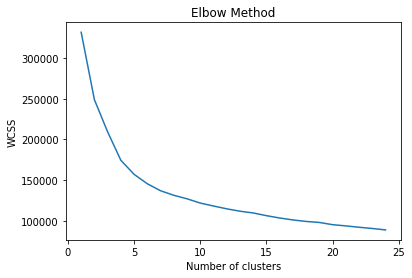

In [40]:
# Use the elbow visual as guide to decide how many clusters we want to use; WCSS within cluster sum of squares
wcss = []

for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=4343, algorithm='auto')
    kmeans.fit(kmeans_input)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

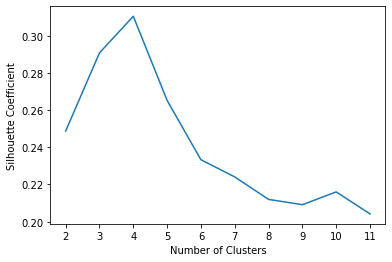

In [41]:
# Use the silhouette measure as guide to decide how many clusters we want to use
silhouette_coefficients = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=4343, algorithm='auto')
    kmeans.fit(kmeans_input)
    score = silhouette_score(kmeans_input, kmeans.labels_, metric='euclidean')
    silhouette_coefficients.append(score)
plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [45]:
# Set k-means to 4 clusters
kmeans4 = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=4343, algorithm='auto')
kmeans4.fit(kmeans_input)

# Save clusters
clusters4 = kmeans4.fit_predict(kmeans_input)

In [46]:
# Save cluster solution in your dataframe, you can alsways enter multiple solutions
df_input['cluster_solution4'] = pd.Series(clusters4, index=df_input.index)


## Evaluate 

- size of clusters
- visualize results of clusters > dimension reduction
- plot cluster solution against various different characteristics
- interprete meaning: is this solution usefull for our task?


In [47]:
# How big are our clusters?
df_input['cluster_solution4'].value_counts()

1    12031
2     9883
0     3371
3     2352
Name: cluster_solution4, dtype: int64

In [ ]:
#df_input['cluster_solution8'].value_counts()

In [48]:
# Visualise cluster solution along two dimensions (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(kmeans_input.values)

<AxesSubplot:xlabel='pca-1', ylabel='pca-2'>

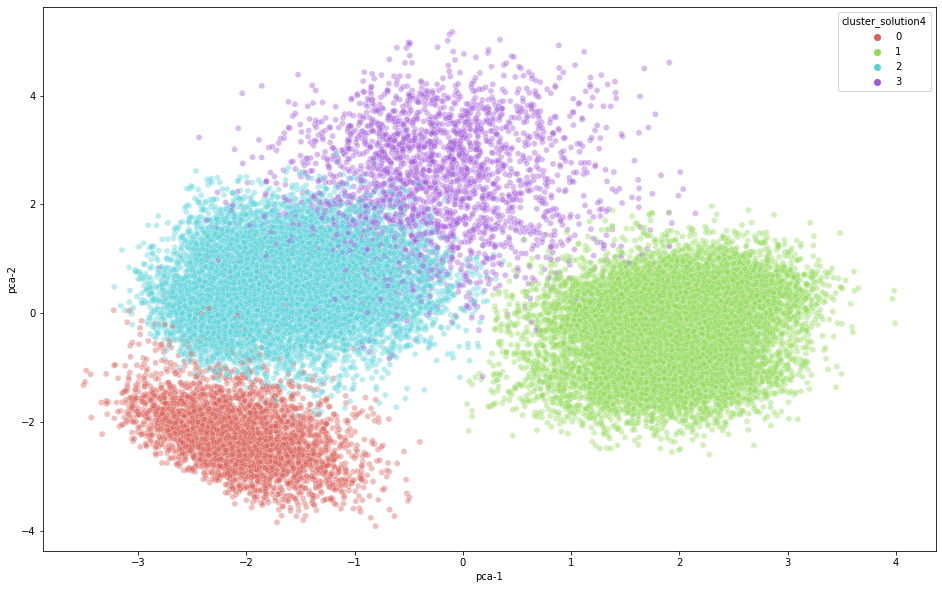

In [49]:
# Add dimensions to our input dataframe
df_input['pca-1'] = pca_result[:,0]
df_input['pca-2'] = pca_result[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue="cluster_solution4",
    palette=sns.color_palette("hls", 4),
    data=df_input,
    legend="full",
    alpha=0.4
)

In [51]:
# Look at mean differences between clusters
df_input.groupby(
   ['cluster_solution4']
).agg(
    {
         'customers_id': 'count',
         'age': 'mean',                
         'urbanisation' : 'mean',
         'GB_usage_month': 'mean',
         'service_year': 'mean',
         'service_calls_year': 'mean',
         'survey_news': 'mean',
         'survey_usage': 'mean',
         'survey_support': 'mean',
         'survey_changes': 'mean',  
         'mechanic_year': 'mean',
         'perc_payment_on_time': 'mean',
         'NPS': 'mean',
         'optin_Y': 'mean',
         'Acc_Login': 'mean',
         'gender_M': 'mean',
         'CL_> 5 years': 'mean',
         'CL_less then 24 months': 'mean'
    }
).reset_index()

,cluster_solution4,customers_id,age,urbanisation,GB_usage_month,service_year,service_calls_year,survey_news,survey_usage,survey_support,survey_changes,mechanic_year,perc_payment_on_time,NPS,optin_Y,Acc_Login,gender_M,CL_> 5 years,CL_less then 24 months
0,0,3371,21.251557,1.924355,43.260753,0.018096,0.000297,4.303483,2.888713,4.548936,3.247286,0.001780,0.994684,7.672204,0.654405,0.492732,0.482053,0.000000,0.998517
1,1,12031,33.017372,1.000582,76.094672,13.774665,3.196742,3.461861,3.577884,2.564111,3.611017,1.060760,0.982496,5.892611,0.226332,0.602277,0.442025,0.999584,0.000000
2,2,9883,29.013255,2.420419,12.309521,0.086917,0.000911,3.455612,2.202368,4.338377,2.624274,0.008601,0.996186,6.179905,0.713852,0.639684,0.204695,0.504300,0.000708
3,3,2352,51.582908,1.494048,4.445578,13.949830,0.059524,3.919708,2.403659,2.208372,2.769156,1.389031,0.395170,5.911565,0.199830,0.908588,0.444303,0.213861,0.036565


In [52]:
df_input.to_excel('20220531_FD_INPUTvDION.xlsx', index = False)

ModuleNotFoundError: No module named 'openpyxl'

<AxesSubplot:xlabel='NPS'>

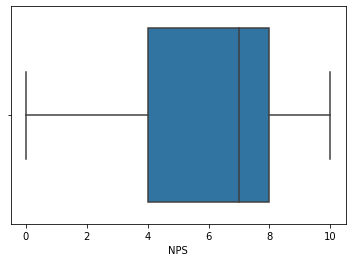

In [38]:
sns.boxplot(x=df_input['NPS'])

In [ ]:
#sns.scatterplot(x=df_input['cluster_solution8'], y=df_input['NPS'])

In [ ]:
df['NPS'].hist(bins=100)

C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

Text(0.5, 1.0, 'Distribution of customer age')

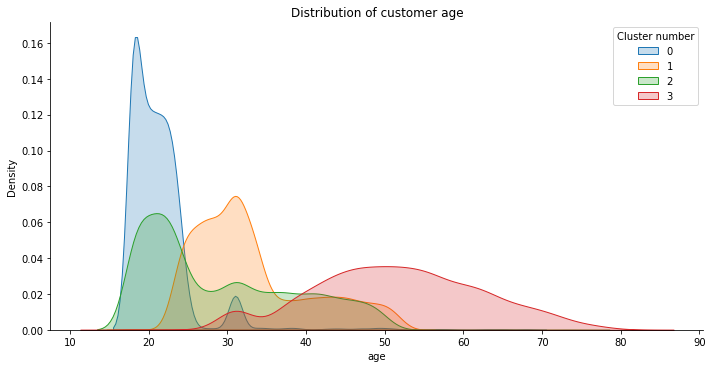

In [53]:
# Looking at the mean value is sometimes not that informative, display the distribution of age for example
sns.FacetGrid(df_input
              ,hue="cluster_solution4"
              ,height=5, aspect=2).map(sns.distplot, "age", label="cluster_solution3", hist=False, kde_kws={"shade": True})
plt.legend(title="Cluster number")
plt.title('Distribution of customer age')


C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

Text(0.5, 1.0, 'Distribution of website usage for online support')

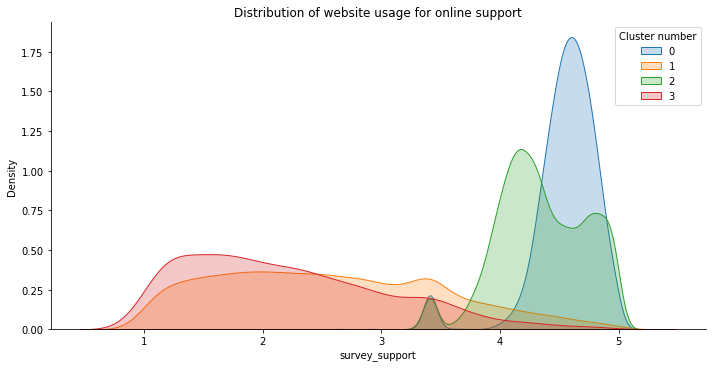

In [54]:
# Display the distribution of GB usage per month
sns.FacetGrid(df_input
              ,hue="cluster_solution4"
              ,height=5, aspect=2).map(sns.distplot, "survey_support", label="cluster_solution", hist=False, kde_kws={"shade": True})
plt.legend(title="Cluster number")
plt.title('Distribution of website usage for online support')

C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\daffourtit\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

Text(0.5, 1.0, 'Distribution of GB usage per month')

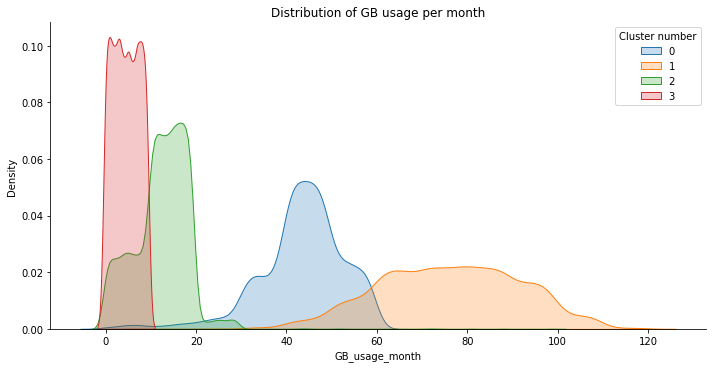

In [55]:
# Display the distribution of GB usage per month
sns.FacetGrid(df_input
              ,hue="cluster_solution4"
              ,height=5, aspect=2).map(sns.distplot, "GB_usage_month", label="cluster_solution", hist=False, kde_kws={"shade": True})
plt.legend(title="Cluster number")
plt.title('Distribution of GB usage per month')


## Save results

- Merge other features for exploratory analysis
- Save file to CSV


In [ ]:
# Create ouput dataframe: non-numeric fields to keep and Kmeans input
df_save = pd.merge(df[['customers_id', 'subscription', 'subscription_add_on', 'customer_lifetime']], df_input, on='customers_id')

# Subset final dataframe and upload to SQL-server
df_save.to_csv('wvg_cluster_solution.csv', index = False, sep = ';', decimal = ',')